In [88]:
from pymatgen.ext.matproj import MPRester
from pymatgen import Lattice,Structure,Molecule
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from jupyter_jsmol import JsmolView
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
import matplotlib.pyplot as plt

from jupyter_jsmol.pymatgen import quick_view

In [89]:
with MPRester("T8fAP9J6w3C63ALkqu8u") as m:
    struct = m.get_structure_by_material_id("mp-924129") #récupère les données du crystal sur MP 
    band_struct = m.get_bandstructure_by_material_id("mp-924129")#récupère les données sur la structure des bandes

symmetry = SpacegroupAnalyzer(struct) #Pour les analyses de symmétrie du crystal
structure = symmetry.get_conventional_standard_structure() #donne la maille conventionnelle
lattice = structure.lattice #Le réseau conventionnel
latticeR = lattice.reciprocal_lattice#le réseau réciproque

sym = SpacegroupAnalyzer(structure).get_symmetry_operations()

xrdc = XRDCalculator(1.54060) #initialise le XRD calculator
pattern = xrdc.get_pattern(structure) #représentation du pattern de diffraction



Bande interdite

In [90]:
band_gap = band_struct.get_band_gap()
energy = band_gap['energy']
direct = band_gap['direct']
kpoint = band_gap['transition']
print(' Energie du gap : {}eV \n Bande direct ? {} \n Vecteur k de transition : {}'.format(energy,direct,kpoint))

 Energie du gap : 0.4952999999999994eV 
 Bande direct ? False 
 Vecteur k de transition : \Gamma-X


Dispersion

In [91]:
#trouver le point le plus haut de la bande de valence et calculer le vecteur k associé
vbm = band_struct.get_vbm()
energy_vbm = vbm['energy']
kpoint_vbm = vbm['kpoint'].cart_coords
print(' Energie du point le plus haut de la bande : {}eV \n coordonées cartésiennes du vecteur k associé {}'.format(energy_vbm,kpoint_vbm))

 Energie du point le plus haut de la bande : 6.4915eV 
 coordonées cartésiennes du vecteur k associé [0. 0. 0.]


In [92]:
#trouver le point le plus bas de la bande de conduction et calculer le vecteur k associé
cbm = band_struct.get_cbm()
energy_cbm = cbm['energy']
kpoint_cbm = cbm['kpoint'].cart_coords
print(' Energie du point le plus bas de la bande : {}eV \n coordonées cartésiennes du vecteur k associé {}'.format(energy_cbm,kpoint_cbm))

 Energie du point le plus bas de la bande : 6.9868eV 
 coordonées cartésiennes du vecteur k associé [0.         1.01956066 0.        ]


In [111]:
data = plotter.BSPlotter(band_struct).bs_plot_data()
abscisse = data.get('ticks').get('distance')
energy = data.get('energy')
i = 0
k = 0
dx = np.zeros(10)
dy1 = np.zeros([10,3])
dy2 = np.zeros(10)

vbm_band = vbm.get('band_index') # donne les index des bandes vdm : 18,19,20
cbm_band = cbm.get('band_index') # donne les index des bandes cdm : 21
print('vbm:',vbm_band,'cbm:',cbm_band)

index_vbm = [18,19,20]
index_cbm = 21
while i < len(abscisse)-1:
    dx[k] = abscisse[i]-abscisse[i+1]
    
    for j in range(len(index_vbm)):
        
        dy1[k][j] = energy['1'][k][index_vbm[j]][-1] - energy['1'][k][index_vbm[j]][0]
        
    dy2[k] = energy['1'][k][index_cbm][-1] - energy['1'][k][index_cbm][0]
    i+= 1
    if (i<len(abscisse)-1):
        if(abscisse[i] == abscisse[i+1]):
            i +=1
    k+=1

pente1 = np.zeros([10,3])
pente2 = np.zeros(10)
for i in range(len(dx)):
    for j in range(3):
        pente1[i][j] = dy1[i][j]/dx[i]
        pente2[i] = dy2[i]/dx[i]
    
maxv = np.zeros(10)
minv = np.zeros(10)
print(pente1)
for i in range(10):
    maxv[i] = np.max(pente1[i])
    minv[i] = np.min(pente1[i])
print('dispersion max dans la bande de valence',np.max(abs(maxv)))
print('dispersion min dans la bande de valence',np.min(abs(maxv)))
print('dispersion max dans la bande de conduction',np.max(abs(pente2)))
print('dispersion min dans la bande de conduction',np.min(abs(pente2)))



vbm: defaultdict(<class 'list'>, {<Spin.up: 1>: [18, 19, 20]}) cbm: defaultdict(<class 'list'>, {<Spin.up: 1>: [21]})
dispersion max dans la bande de valence 2.1468070369636902
dispersion min dans la bande de valence 0.07601205719365385
dispersion max dans la bande de conduction 2.2805901509265225
dispersion min dans la bande de conduction 0.26365698071677585


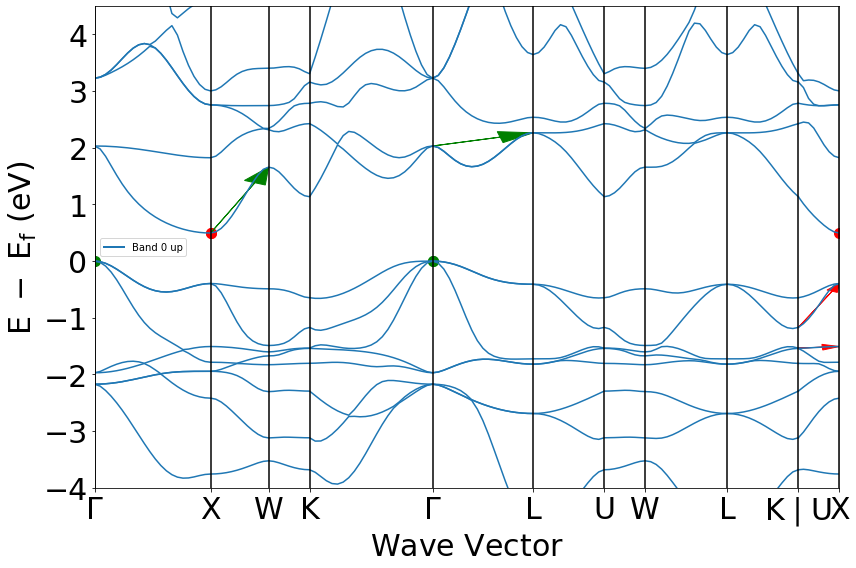

In [118]:
BSPlotter(band_struct).get_plot(vbm_cbm_marker=True)
plt.arrow(abscisse[17], energy['1'][9][18][0], abs(dx[9]), dy1[9][0], color = 'r', head_width = 0.1,length_includes_head=True)
plt.arrow(abscisse[17], energy['1'][9][19][0], abs(dx[9]), dy1[9][1], color = 'r', head_width = 0.1,length_includes_head=True)
plt.arrow(abscisse[1], energy['1'][1][21][0], abs(dx[1]), dy2[1], color = 'g', head_width = 0.2,length_includes_head=True)
plt.arrow(abscisse[8], energy['1'][4][21][0], abs(dx[4]), dy2[4], color = 'g', head_width = 0.2,length_includes_head=True)

plt.show()

plus la pente est grande plus la dispersion est élevée

Masse éffective:
m* = k^2/(2*Ek)

In [141]:
hb = 6.62607015e-34
me = 9.1094e-31
meffv = (kpoint_vbm[0]**2+kpoint_vbm[1]**2+kpoint_vbm[2]**2)/(2*energy['1'][0][20][0]+1)
meffc = (kpoint_cbm[0]**2+kpoint_cbm[1]**2+kpoint_cbm[2]**2)/(2*energy['1'][1][21][0])

print('masse éffective de la bande de valence :',meffv)# 0 car le vecteur k = [0,0,0] mais ça me parait un peu bizarre
print('masse éffective de la bande de conduction :',meffc)

masse éffective de la bande de valence : 0.0
masse éffective de la bande de conduction : 1.0493679990865932
